# INCAWrapper validation case small toy model
This notebook serves as a validation case the show that the INCAWrapper produce similar results as a model run through the INCA GUI. Here we compare the MCMC samples from the INCAWrapper to MCMC samples obtain from the GUI. 

This notebook is not meant as a tutorial and therefore code description is a bit more sparse. For a proper tutorial see the other examples at https://incawrapper.readthedocs.io/en/latest/examples/index.html.

## Introduction
In this validation case, we will use a simple toy model has been used in the literature to study 13C-MFA [1], [2]. The model contains 5 reactions and 6 metabolites. To ensure that we can obtain a good fits to the data, we employ a simulated dataset for this validation. The simulated dataset holds one experiment in which the network is fed a labelled version of the metabolite A ([2-C13]-A).

## Method for INCA GUI based flux estimation and MCMC sampling
The model, experiments and data was manually entered into the INCA GUI. This model was saved to a file (`docs/examples/Literature data/simple model/simple_model_mcmc_validation_gui_model.mat`). We then ran first the estimate, then clicked `Update model`, and the second `Monte carlo sampling` after sampling has converged we used `save fluxmap as` to save the results a file (`docs/examples/Literature data/simple model/simple_model_mcmc_validation_gui_fluxmap.mat`).

### Extracting MCMC samples from INCA GUI
As noted in the MCMC tutorial for the INCAWrapper, it is currently not capable of loading MCMC results if the MCMC has ben run through the GUI. Therefore we have exported the GUI samples through the Matlab command line, using the the following workflow:
- Open INCA 
- In INCA open the fluxmap containing the MCMC samples
- In Matlab command line: run `csvwrite('simple_model_gui_mcmc_results.csv', f.par.vals)`

## Method for INCAWrapper flux estimation and MCMC sampling
The MCMC was run through the incawrapper using the the Python script `docs/examples/Literature data/simple model/incawrapper_mcmc.py`.

## Note about randomness in INCA
When INCA estimates the flux distribution it deploys an optimisation algorithm, which searches for a local optimum in the parameter space. To increase the probability that the found flux distribution is a global optimum INCA can be configured to restart the optimisation algorithm at different point in the parameter space. Unfortunately, the INCA manual do not describe any method to set the random seed for random restarts, thus the best we can do is to a large number of restarts in both the INCA GUI and the INCAWrapper to improve the probability that the two executions finds the same optimum. Therefore, we used 1000 restarts during flux estimation in both the INCAWrapper and the INCA GUI. Once an optimum was found for the two models, we performed MCMC sampling both through the GUI and the wrapper. In this notebook we compare these samples to explore if they could be draw from the same population, i.e. the differences in flux solution between the GUI and the Wrapper are likely due to randomness.

## Setting up the environment
First, we will setup the coding environment, load packages, set pah to files and read-in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import incawrapper
import ast
PROJECT_DIR = pathlib.Path().cwd().parents[1].resolve()
data_directory = PROJECT_DIR / pathlib.Path("docs/examples/Literature data/simple model")

In [2]:
# File for which MCMC is started from
incawrapper_fluxmap_file = data_directory / 'simple_model_incawrapper_fluxmap_mcmc.mat'
# gui_fluxmap_file = data_directory / 

# MCMC samples
incawrapper_mcmc_samples_file = data_directory / "simulated_data" / "simple_model_incawrapper_mcmc_results.csv"
gui_mcmc_samples_file = data_directory / "simulated_data" / "simple_model_gui_mcmc_results.csv"

# Hotelling T2 test results
hotelling_result_file = data_directory / 'simulated_data' / 'hotelling_test_results.txt'

We will load the MCMC results and save the samples to a csv file.

In [3]:
incawrapper_flux_samples = pd.read_csv(incawrapper_mcmc_samples_file, index_col=None)

# prepare long format
incawrapper_flux_samples['sample'] = incawrapper_flux_samples.index.values
incawrapper_flux_samples_long = pd.melt(incawrapper_flux_samples, id_vars='sample', var_name='reaction', value_name='flux')
incawrapper_flux_samples_long['source'] = 'INCAwrapper'
incawrapper_flux_samples_long.head()

,sample,reaction,flux,source
0,0,R1,99.868174,INCAwrapper
1,1,R1,99.531294,INCAwrapper
2,2,R1,99.752950,INCAwrapper
3,3,R1,99.924800,INCAwrapper
4,4,R1,99.498449,INCAwrapper


In [4]:
# Load GUI flux samples
gui_flux_samples = pd.read_csv(gui_mcmc_samples_file, index_col=None)
gui_flux_samples['sample'] = gui_flux_samples.index.values
gui_flux_samples.columns = incawrapper_flux_samples.columns

gui_flux_samples_long = gui_flux_samples.melt(id_vars='sample', var_name='reaction', value_name='flux')
gui_flux_samples_long['source'] = 'GUI'
gui_flux_samples_long.head()

,sample,reaction,flux,source
0,0,R1,99.584,GUI
1,1,R1,99.342,GUI
2,2,R1,99.934,GUI
3,3,R1,99.811,GUI
4,4,R1,99.748,GUI


<Axes: xlabel='reaction', ylabel='flux'>

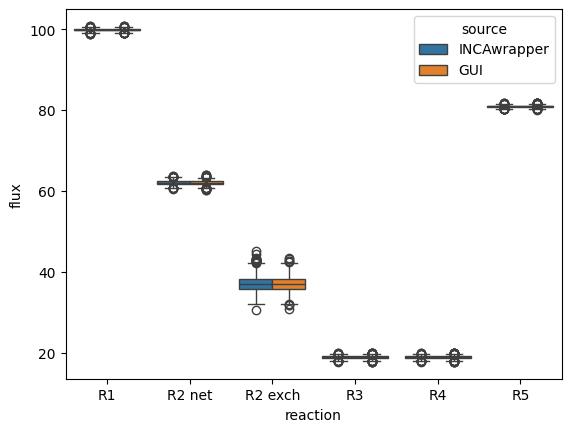

In [5]:
# setup a plotting data frame
plot_df = pd.concat([incawrapper_flux_samples_long, gui_flux_samples_long])
sns.boxplot(data=plot_df, x='reaction', y='flux', hue='source')

The plot shows that the MCMC samples appear very comparable. However, we now wish to conduct a statistical comparison between the samples of flux distributions obtained from the INCAWrapper and the GUI. To do this we will use a Hotelling's $t^2$ test, which is capable of comparing multivariate means. The most appropriate implementation that we could find was in R. Therefore the test is conducted the R script, `compare_mcmc_samples.R`. Now we fetch the results of the test.

In [6]:
pd.read_csv(hotelling_result_file, sep=' ', index_col=0)

,value
p_value,0.364359
degree_of_freedom_1,3.000000
degree_of_freedom_2,5696.000000
n_permutations,1000000.000000


We see that the hotelling's $t^2$ test find that there is no evidence that samples from the GUI and INCAWrapper come from different distributions.

## Conclusion


As the MCMC samples from the INCAWrapper and the GUI was not significantly different (alpha = 0.05), we conclude that the two methods explore the flux space and thus the differences in the results can be attributed to randomness.

## References
[1] M. R. Antoniewicz, J. K. Kelleher, and G. Stephanopoulos, “Determination of confidence intervals of metabolic fluxes estimated from stable isotope measurements,” Metabolic Engineering, vol. 8, no. 4, pp. 324–337, Jul. 2006, doi: 10.1016/j.ymben.2006.01.004.

[2] M. R. Antoniewicz, J. K. Kelleher, and G. Stephanopoulos, “Elementary metabolite units (EMU): A novel framework for modeling isotopic distributions,” Metabolic Engineering, vol. 9, no. 1, pp. 68–86, Jan. 2007, doi: 10.1016/j.ymben.2006.09.001.
